In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
proj_path = '/content/drive/MyDrive/Model Development '
os.chdir(proj_path)
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1_QHmZZAWiu1Idc_qP56o_8AWHyZMtSIR/Model Development '

In [3]:
#Imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
!pip install -q pydot
!pip install graphviz
!pip install pydotplus
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
#image sizing
IMAGE_SIZE=[224,224,3]
train_path='/content/drive/MyDrive/Model Development /tbdataset/Train'
valid_path='/content/drive/MyDrive/Model Development /tbdataset/Test'

In [5]:
# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Preprocessing the Train set
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Model Development /tbdataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Model Development /tbdataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 3167 images belonging to 2 classes.
Found 791 images belonging to 2 classes.


In [20]:
IMAGE_SIZE = (224,224,3)

import tensorflow as tf
vgg19 = tf.keras.applications.vgg19.VGG19(
    input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in vgg19.layers:
    layer._name = layer._name + str('_19')
    layer.trainable = False

effnetb1 =tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)
for layer in effnetb1.layers:
    layer._name = layer._name + str('_B1')
    layer.trainable=False

densenet=tf.keras.applications.densenet.DenseNet121(
    include_top=False, weights="imagenet", input_shape=IMAGE_SIZE)
for layer in densenet.layers:
    layer._name = layer._name + str('_Dense')
    layer.trainable=False

In [22]:
from tensorflow.keras.layers import Input, Flatten, Concatenate, Dense, Average, Dropout
inp = Input(IMAGE_SIZE)
    
vgg19_x = Flatten()(vgg19(inp))
vgg19_x = Dense(256, activation='relu')(vgg19_x)

effnet_x = Flatten()(effnetb1(inp))
effnet_x = Dense(256, activation='relu')(effnet_x)

densenet_x = Flatten()(densenet(inp))
densenet_x = Dense(256, activation='relu')(densenet_x)

In [26]:
class LinearW(Layer):

    def __init__(self):
        super(LinearW, self).__init__()
        
    def build(self, input_shape):
        
        self.W = self.add_weight(
                    shape=(1,1,len(input_shape)),
                    initializer='uniform',
                    dtype=tf.float32,
                    trainable=True)
        
    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim

        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

NameError: ignored

In [23]:
from tensorflow.keras.models import Model

x = LinearW()([vgg19_x, effnet_x, densenet_x])
x = Dense(128, activation='relu')(x)
x = Dropout(0.30)(x)
x = Dense(128, activation='relu')(x)
out = Dense(2, activation='softmax')(x)

model = Model(inputs = inp, outputs = out)
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    name="Adam"),
  metrics=['accuracy']
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    input_8[0][0]                    
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 7, 7, 1280)   6575239     input_8[0][0]                    
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 7, 7, 1024)   7037504     input_8[0][0]                    
____________________________________________________________________________________________

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)

In [25]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks = [es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
99/99 [==============================] - 1930s 19s/step - loss: 1.6421 - accuracy: 0.5311 - val_loss: 0.6361 - val_accuracy: 0.4994
Epoch 2/20
25/99 [======>.......................] - ETA: 2:05 - loss: 0.8480 - accuracy: 0.5225

KeyboardInterrupt: ignored

In [ ]:
predictions = model.predict(test_set, steps = test_set.n // 31, verbose=1)

25/25 [==============================] - 39s 1s/step


In [ ]:
y_classes = predictions.argmax(axis=1)

In [ ]:
y_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('Confusion Matrix:')
print(confusion_matrix(test_set.classes, y_classes))

print("Accuracy : " ,accuracy_score(test_set.classes, y_classes))
print("Precision : " ,precision_score(test_set.classes, y_classes))
print("Recall : " ,recall_score(test_set.classes, y_classes))
print("F1 Score : " ,f1_score(test_set.classes, y_classes))

Confusion Matrix:
[[394   3]
 [ 68 326]]
Accuracy :  0.9102402022756005
Precision :  0.9908814589665653
Recall :  0.8274111675126904
F1 Score :  0.9017980636237898


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(test_set.classes, y_classes)
print("SVM Area under curve -> ",auc(fpr, tpr))

SVM Area under curve ->  0.9099272462248591


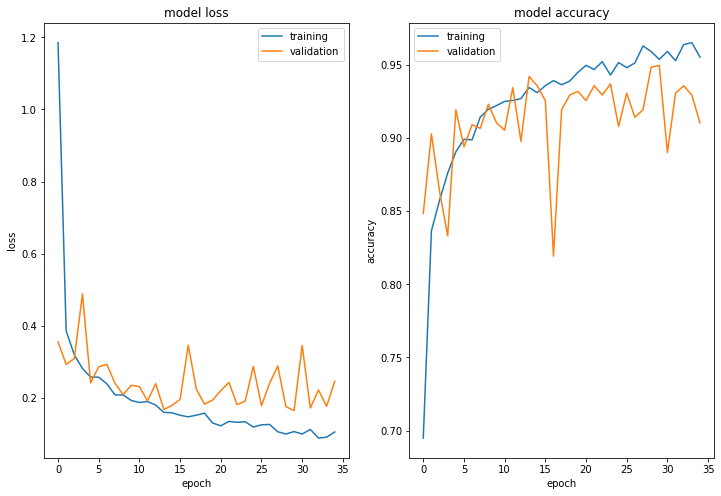

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.plot(r.history['loss'])
T_loss = r.history['loss']
plt.plot(r.history['val_loss'])
V_loss = r.history['val_loss']
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
  
plt.subplot(1,2,2)
plt.plot(r.history['accuracy'])
T_acc = r.history['accuracy']
plt.plot(r.history['val_accuracy'])
V_acc = r.history['val_accuracy']
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')